## Feature Extraction (CNN) and similarity

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage 

import os
import cv2
import pandas as pd
%matplotlib inline

In [60]:
#Load the coordinates data set
df = pd.read_csv('train.csv')

In [263]:
# Load images and resize 
root= './train'
names = []
train_crude = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file))#,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img.shape[1]//3,img.shape[0]//3))
    train_crude.append(img)
    names.append(file.split('.')[0])
    
data = np.stack( train_crude, axis=0 )

In [264]:
train_crude[0].shape

(163, 226, 3)

In [265]:
data.shape

(7500, 163, 226, 3)

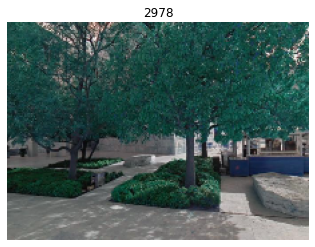

In [266]:
plt.imshow(data[0], cmap='gray')  
plt.title(im)
plt.axis('off')
plt.show()

### Extract Features

#### CNN pre-trained

In [270]:
from tensorflow.keras.applications.vgg19 import VGG19

base_model = VGG19(weights='imagenet', input_shape=[163, 226,3],include_top=False) 

In [271]:
#base_model.summary()

In [272]:
#get features and flatten
feat = base_model.predict(data)
feat2 = [i.ravel() for i in feat]
feat2 = np.stack(feat2, axis=0)

In [273]:
feat2.shape

(7500, 17920)

##### Visualise Nearest neighbors

In [274]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(feat2)

NearestNeighbors(n_neighbors=6)

<AxesSubplot:xlabel='x', ylabel='y'>

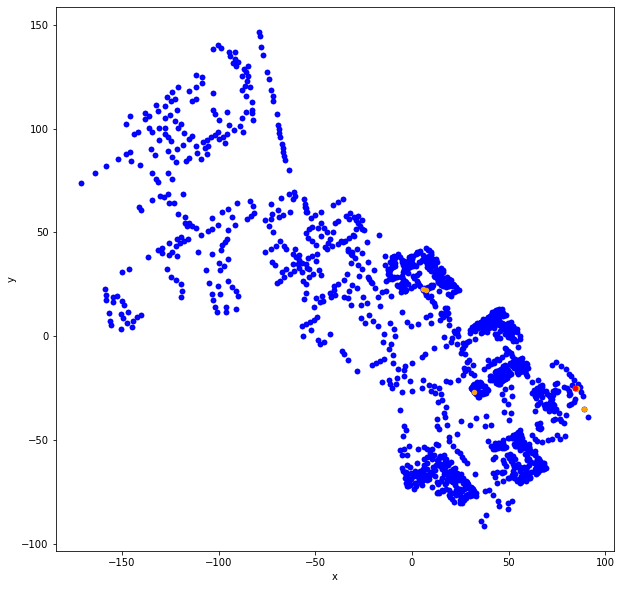

In [275]:
example =300
nn = neigh.kneighbors(np.expand_dims(feat2[example], axis=0))
predictions = nn[1].tolist()[0]

original = df.iloc[example:example+1]
sample = df.iloc[predictions]
controls = df
ax = controls.plot(kind='scatter',x='x',y='y',figsize=(10,10), color='blue', alpha=0.5)
ax2 = sample.plot(ax=ax, kind='scatter',x='x',y='y',figsize=(10,10), color='orange')
original.plot(ax=ax2, kind='scatter',x='x',y='y',figsize=(10,10), color='red')


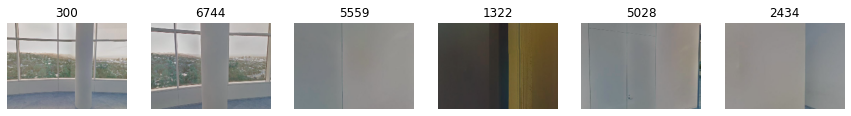

In [276]:
plt.subplots(figsize=(15,15))
for ix,im in enumerate(predictions):
    toShow = data[im]
    plt.subplot(1,6,ix+1)
    plt.imshow(toShow, cmap='gray')  
    plt.title(im)
    plt.axis('off')
plt.show()

##### Absolute Error Results (custom version)

In [277]:
# calculate absolute error
train = feat2[:7001]
test = feat2[7001:]

neighTest = NearestNeighbors(n_neighbors=5)
neighTest.fit(train)

predict = neighTest.kneighbors(test)

In [278]:
#Pseudo prediction by average closest neighbours
#It turns out it works as KNN regressor, but here I can set a similarity quality threshhold.
threshold_distance = 950
result = []
for ix, instance in enumerate(predict[1]):
    x = []
    y = []
    for n, i in enumerate(instance):
        #if no neighbour passes the thresthold, use just the most similar, which is always the first
        if n in [0] or predict[0][ix][n] < threshold_distance:    
            x.append(df.iloc[i].x)
            y.append(df.iloc[i].y)

    result.append([sum(x)/len(x),sum(y)/len(y)])
        

In [279]:
y_true = df[['x','y']].iloc[7001:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, result, multioutput='uniform_average')

34.293608885257605

##### KNN regression version

In [297]:
from sklearn.model_selection import GridSearchCV

parameters = {'metric':('euclidean', 'manhattan','chebyshev'),#'algorithm':('ball_tree', 'kd_tree', 'brute')
              'weights':('uniform', 'distance'), 'n_neighbors': [3,5,7]}
knn = KNeighborsRegressor(n_jobs=-1)
clf = GridSearchCV(knn, parameters, scoring='neg_mean_absolute_error')
clf.fit(feat2[:7001], df[['x','y']].iloc[:7001])

print(clf.best_score_)
clf.best_params_

-34.08494689289202


{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

In [298]:
from sklearn.neighbors import KNeighborsRegressor
neighReg0 = KNeighborsRegressor(n_neighbors=3, metric = 'euclidean', weights='distance')
neighReg0.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictReg0 = neighReg0.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg0, multioutput='uniform_average')

34.77829040725912

#### AUTOENCODER

In [214]:
#reload data in a fitting size for the autoencoder to de code(no inexact divisions)
root= './train'
names = []
train_crude = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (360,280))
    train_crude.append(img)
    names.append(file.split('.')[0])

data = np.stack( train_crude, axis=0 )

In [215]:
data[0].shape

(280, 360)

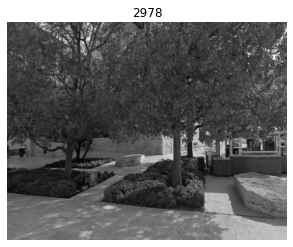

In [216]:
plt.imshow(data[0], cmap='gray')  
plt.title(im)
plt.axis('off')
plt.show()

In [217]:
input_img = keras.Input(shape=(280, 360,1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [218]:
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 280, 360, 1)]     0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 280, 360, 16)      160       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 140, 180, 16)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 140, 180, 8)       1160      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 70, 90, 8)         0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 70, 90, 8)         584       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 35, 45, 8)         0  

In [220]:

autoencoder.fit(data[:7000], data[:7000],
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(data[7000:], data[7000:]))

Epoch 1/50
110/110 [==============================] - 52s 402ms/step - loss: -1767.9202 - val_loss: -1808.7229
Epoch 2/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5150 - val_loss: -1808.7229
Epoch 3/50
110/110 [==============================] - 41s 377ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 4/50
110/110 [==============================] - 41s 373ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 5/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5153 - val_loss: -1808.7230
Epoch 6/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 7/50
110/110 [==============================] - 41s 370ms/step - loss: -1800.5151 - val_loss: -1808.7230
Epoch 8/50
110/110 [==============================] - 41s 375ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 9/50
110/110 [==============================] - 41s 375ms/step - loss: -1800.5149 - val_loss: -1808.7230
E

In [221]:
encoder = keras.Model(input_img, encoded)

In [235]:
encoder_features = encoder.predict(data)
encoder_features = [i.ravel() for i in encoder_features]
encoder_features = np.stack(encoder_features, axis=0)

In [237]:
encoder_features.shape

(7500, 12600)

In [239]:
from sklearn.neighbors import KNeighborsRegressor

neighReg = KNeighborsRegressor(n_neighbors=5)
neighReg.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])
predictReg = neighReg.predict(encoder_features[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg, multioutput='uniform_average')

39.219920000567825

In [257]:
from sklearn.model_selection import GridSearchCV

parameters = {'metric':('euclidean', 'manhattan','chebyshev'),#'algorithm':('ball_tree', 'kd_tree', 'brute')
              'weights':('uniform', 'distance'), 'n_neighbors': [1,2,3,5,10],'n_jobs': [4]}
knn = KNeighborsRegressor()
clf = GridSearchCV(knn, parameters, scoring='neg_mean_absolute_error')
clf.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])

print(clf.best_score_)
clf.best_params_

-37.03590577893906


{'metric': 'manhattan', 'n_jobs': 4, 'n_neighbors': 10, 'weights': 'distance'}

In [281]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.213217,0.017659,5.030996,0.423176,euclidean,4,1,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-47.018750,-47.555214,-48.073714,-48.786571,-46.479679,-47.582786,0.803225,25
1,0.197610,0.006348,4.564031,0.086157,euclidean,4,1,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-47.018750,-47.555214,-48.073714,-48.786571,-46.479679,-47.582786,0.803225,25
2,0.196416,0.004508,4.513096,0.104750,euclidean,4,2,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-42.756161,-42.823589,-44.274268,-44.944911,-43.063982,-43.572582,0.878847,20
3,0.213009,0.015812,4.950998,0.326221,euclidean,4,2,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-42.676606,-42.751364,-44.169609,-44.846863,-43.005243,-43.489937,0.865463,19
4,0.216995,0.008652,4.498116,0.112401,euclidean,4,3,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-41.223071,-41.077810,-42.929595,-43.135095,-41.449702,-41.963055,0.883475,14
5,0.208402,0.001356,4.487600,0.054375,euclidean,4,3,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-41.147340,-40.980152,-42.848500,-43.040543,-41.390511,-41.881409,0.879882,13
6,0.202649,0.003431,4.515605,0.056479,euclidean,4,5,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-40.012064,-39.956221,-41.518100,-41.402121,-39.687479,-40.515197,0.780149,12
7,0.206982,0.008607,4.505409,0.078060,euclidean,4,5,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-39.951656,-39.862734,-41.437735,-41.324903,-39.630182,-40.441442,0.775376,11
8,0.207402,0.004123,4.523387,0.036781,euclidean,4,10,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-38.863493,-38.884943,-40.334779,-40.269457,-38.898425,-39.450219,0.695968,8
9,0.208801,0.003249,4.551638,0.017008,euclidean,4,10,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-38.818635,-38.790535,-40.269245,-40.211524,-38.848654,-39.387719,0.696681,7


In [250]:
neighReg2 = KNeighborsRegressor(n_neighbors=5, metric = 'manhattan', weights='distance')
neighReg2.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])
predictReg = neighReg2.predict(encoder_features[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg, multioutput='uniform_average')

36.357381006532634

##### To test

In [244]:
#load test data
root= './test'
names_id = []
test_matrix = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (360,280))
    test_matrix.append(img)
    names_id.append(file.split('.')[0])

test_data = np.stack( test_matrix, axis=0 )


In [245]:
encoder_features_test = encoder.predict(test_data)
encoder_features_test = [i.ravel() for i in encoder_features_test]
encoder_features_test = np.stack(encoder_features_test, axis=0)

In [247]:
neighReg = KNeighborsRegressor(n_neighbors=5, metric = 'manhattan', weights='distance')
neighReg.fit(encoder_features, df[['x','y']])


KNeighborsRegressor(metric='manhattan', weights='distance')

In [248]:
test_predict = neighReg.predict(encoder_features_test)


In [249]:
test_predict

array([[ 37.68485471, -34.72265119],
       [ 13.60803497,   0.14159319],
       [ 23.25119436, -33.94169914],
       ...,
       [-29.15136877,  24.36858111],
       [ 27.08772355, -73.94742896],
       [ 17.49124652,   2.84351708]])

In [252]:
df_test = pd.read_csv('imagenames.csv')

In [255]:

df_test = pd.concat([df_test,pd.DataFrame(test_predict, columns=['x','y'])], axis=1)

In [258]:
df_test.to_csv('simplePredition', index=False)

In [262]:
names_id[-10:]

['IMG5477_5',
 'IMG5478_4',
 'IMG5479_5',
 'IMG5480_4',
 'IMG5481_2',
 'IMG5482_1',
 'IMG5483_2',
 'IMG5484_4',
 'IMG5485_3',
 'IMG5486_2']

## Baseline score

In [290]:
baseline = np.array([[df.x.mean(), df.y.mean()]*499]).reshape(499,2)
mean_absolute_error(y_true, baseline, multioutput='uniform_average')

44.90939559213609